# Analysis
- describe twitch
- describe steam

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display, clear_output
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import missingno as msno
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from sklearn.decomposition import PCA
import datetime as dt
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

### Load in data

In [3]:
# Steam charts data
steam_data = pd.read_csv(r"data_files\steam_charts_final_clean.csv", parse_dates=["month","release_date"], index_col = "month")

# Global twitch data
twitch_global = pd.read_csv(r"data_files\twitch_global_data_clean.csv", parse_dates = ["date"], index_col = "date")

# Twitch game data
twitch_game = pd.read_csv(r"data_files\twitch_game_data_clean.csv", parse_dates=["date"], index_col = "date")

In [4]:
twitch_global.head()

,Hours_watched,Avg_viewers,Peak_viewers,Streams,Avg_channels,Games_streamed
date,,,,,,
2016-01-31,480241904,646355,1275257,7701675,20076,12149
2016-02-29,441859897,635769,1308032,7038520,20427,12134
2016-03-31,490669308,660389,1591551,7390957,20271,12234
2016-04-30,377975447,525696,1775120,6869719,16791,12282
2016-05-31,449836631,605432,1438962,7535519,19394,12424


In [5]:
twitch_game.head()

,Game,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
date,,,,,,,,,,
2016-01-31,League of Legends,1,94377226,1362044,530270,2903,129172,127021,1833,69.29
2016-01-31,Counter-Strike: Global Offensive,2,47832863,830105,372654,2197,120849,64378,1117,57.62
2016-01-31,Dota 2,3,45185893,433397,315083,1100,44074,60815,583,104.26
2016-01-31,Hearthstone,4,39936159,235903,131357,517,36170,53749,317,169.29
2016-01-31,Call of Duty: Black Ops III,5,16153057,1151578,71639,3620,214054,21740,1549,14.03


In [6]:
steam_data.head()

,average_players,peak_players,app_id,game,player_gain,player_gain_percentage,short_description,required_age,dlc,supported_languages,developers,publishers,platforms,categories,genres,achievements,release_date,supported_audio,price_usd,review_score,total_positive,total_negative,rating,total_owners_estimated,average_playtime,median_playtime,tags,metacritic_score,metacritic_url,is_recurring_subscription,year,month_name,release_year,release_month,age
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-30,570825.94,923996,730,Counter-Strike: Global Offensive,5864.20,1.04,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,June,2012,8,10
2022-05-31,564961.70,923996,730,Counter-Strike: Global Offensive,-4021.46,-0.71,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,May,2012,8,10
2022-04-30,568983.16,1013237,730,Counter-Strike: Global Offensive,-12506.53,-2.15,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,April,2012,8,10
2022-03-31,581489.69,987993,730,Counter-Strike: Global Offensive,-53148.71,-8.37,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,March,2012,8,10
2022-02-28,634638.40,995163,730,Counter-Strike: Global Offensive,32262.13,5.36,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,February,2012,8,10


In [7]:
steam_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51942 entries, 2022-06-30 to 2020-02-29
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   average_players            51942 non-null  float64       
 1   peak_players               51942 non-null  int64         
 2   app_id                     51942 non-null  int64         
 3   game                       51942 non-null  object        
 4   player_gain                51942 non-null  float64       
 5   player_gain_percentage     51942 non-null  float64       
 6   short_description          47466 non-null  object        
 7   required_age               51942 non-null  float64       
 8   dlc                        29870 non-null  object        
 9   supported_languages        47466 non-null  object        
 10  developers                 47466 non-null  object        
 11  publishers                 47466 non-null  object 

The median and mean of player_gain are close enough that the mean can be used to group by the game column

In [8]:
steam_data.resample("M")["average_players"].sum()

month
2012-07-31    364991.50
2012-08-31    361450.66
2012-09-30    415899.23
2012-10-31    384608.86
2012-11-30    394558.23
                ...    
2022-02-28   5718554.14
2022-03-31   5434299.62
2022-04-30   5106030.68
2022-05-31   5163519.50
2022-06-30   5251685.78
Freq: M, Name: average_players, Length: 120, dtype: float64

In [9]:
steam_data

,average_players,peak_players,app_id,game,player_gain,player_gain_percentage,short_description,required_age,dlc,supported_languages,developers,publishers,platforms,categories,genres,achievements,release_date,supported_audio,price_usd,review_score,total_positive,total_negative,rating,total_owners_estimated,average_playtime,median_playtime,tags,metacritic_score,metacritic_url,is_recurring_subscription,year,month_name,release_year,release_month,age
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-30,570825.94,923996,730,Counter-Strike: Global Offensive,5864.20,1.04,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,June,2012,8,10
2022-05-31,564961.70,923996,730,Counter-Strike: Global Offensive,-4021.46,-0.71,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,May,2012,8,10
2022-04-30,568983.16,1013237,730,Counter-Strike: Global Offensive,-12506.53,-2.15,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,April,2012,8,10
2022-03-31,581489.69,987993,730,Counter-Strike: Global Offensive,-53148.71,-8.37,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,March,2012,8,10
2022-02-28,634638.40,995163,730,Counter-Strike: Global Offensive,32262.13,5.36,Counter-Strike: Global Offensive (CS: GO) expa...,0.00,True,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['Valve', 'Hidden Path Entertainment']",['Valve'],"['windows', 'mac', 'linux']","['Multi-player', 'Steam Achievements', 'Full c...","['Action', 'Free to Play']",167.00,2012-08-21,[' English'],0.00,8.00,2949363.00,439344.00,86.63,50000000-100000000,30053.00,6104.00,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...",83.00,https://www.metacritic.com/game/pc/counter-str...,False,2022,February,2012,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,444.60,1019,625960,Stoneshard,-37.79,-7.83,Stoneshard is a challenging turn-based RPG set...,0.00,True,"['English', 'French', 'German', 'Italian', 'Ja...",['Ink Stains Games'],['HypeTrain Digital'],"['windows', 'linux']","['Single-player', 'Captions available', 'Remot...","['Adventure', 'Indie', 'RPG', 'Strategy', 'Ear...",54.00,2020-02-06,NaN,26.71,6.00,15281.00,4705.00,75.12,500000-10

### Column relationships for global twitch data
The twitch global dataset describes **overall** metrics for audience participation and channel information. This dataset excludes individual game data, which has been separated into its own dataset.

In the chart below, *Twitch global data correlations*, you'll see values of 0.88 and above. This indicates a strong positive relationship for the variables of this dataset. For example, as values in the column "Hours_watched" increase or decrease, the values in "Avg_viewers" follow the same trend (increase/decrease). However, correlation is not causation, thus an increase in one variable (column) does not neccessarily mean it directly influences another variable.

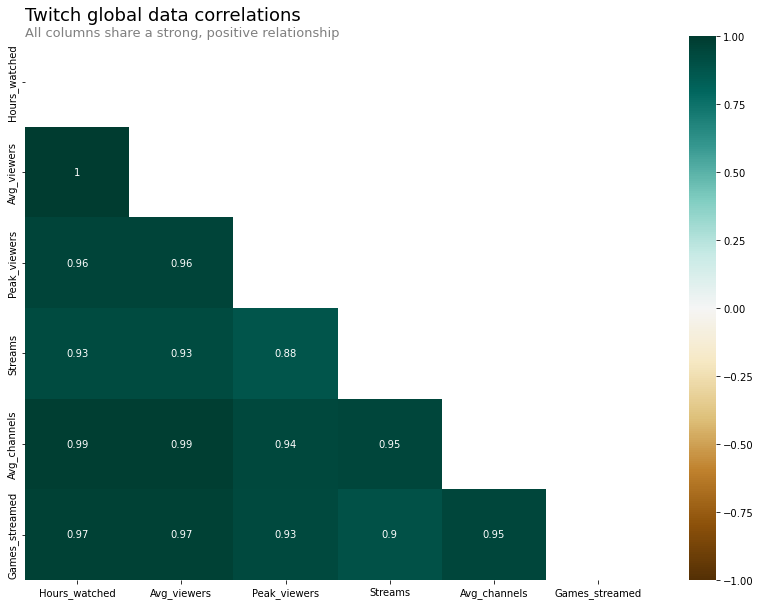

In [10]:
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(twitch_global.corr(), dtype=bool))

heatmap = sns.heatmap(twitch_global.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title("Twitch global data correlations", fontdict={'fontsize':18}, pad=16, loc = "left")
plt.text(x = 0, y = 0, s = "All columns share a strong, positive relationship ", size = 13, color = "grey")
plt.show()

### Steam and Twitch general trends

The two charts below, *Steam: total monthly players (2012 - 2022)*, and *Twitch: total monthly viewers (2016 - 2022)*, visualize consumer trends for Valve's Steam client, and Amazon's video game streaming platform.

Do these two platforms have a viable audience? The data shows that since 2012, the total number of people using Valve's client has seen positive growth. The current information suggests that Steam is still a widely used application for PC gaming.

Total monthly users reflect a smaller portion than the true total monthly players. The reason for this is that the analyzed data is a sample of 1,000 games out of the 60,000+ library available on Steam.
However, I think it's fair to say that the popularity of Valve's Steam client is gaining in popularity.

Twitch's audience shows a similar trend since 2016. Interestingly, there is a large spike in the average number of hours watched in 2020. It's likely this was caused by the COVID-19 lockdowns. As more people stayed home, Twitch was a form of entertainment for millions of people.



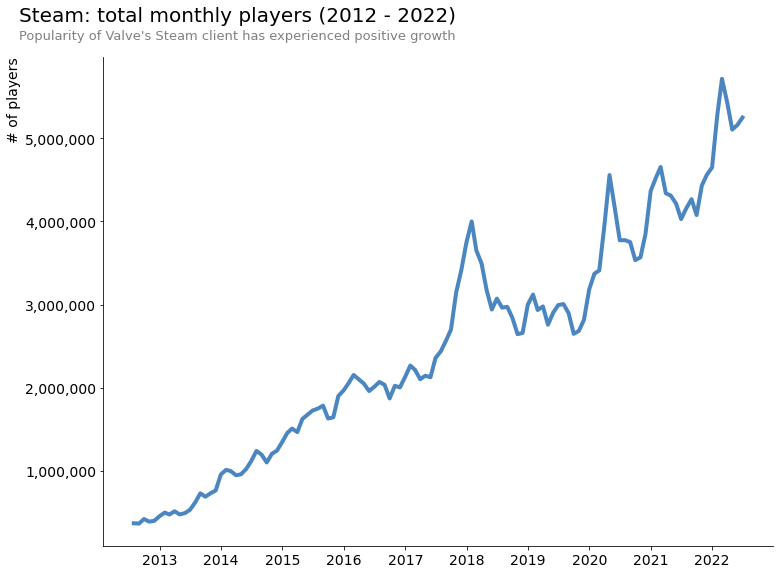

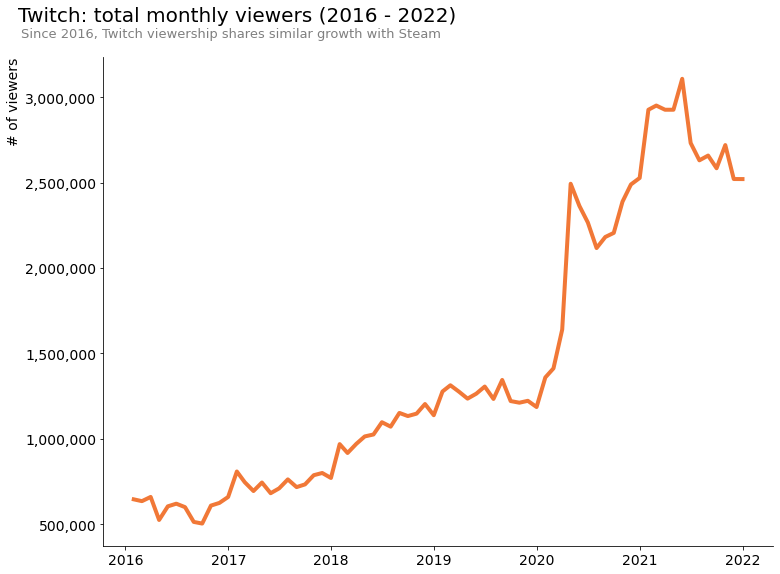

In [11]:

# Plot results
fig, ax = plt.subplots(figsize = (12,9))

# Resample the player data on a monthly scale, calculate the sum
plt.plot(steam_data.resample("M")["average_players"].sum(), color = "#4B86C1", linewidth = 4)

# Remove borders
plt.gca().spines[["right", "top"]].set_visible(False)

# Change y tick labels to non-scientific notation
ax.ticklabel_format(useOffset=False, style='plain', axis = "y")

# Set x axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Title and subtext
plt.title("Steam: total monthly players (2012 - 2022)", size = 20, x = 0.2, y = 1.06)
plt.text(x = 14870, y = 6200000, 
s= "Popularity of Valve's Steam client has experienced positive growth", size = 13, color = "grey")


# Labels and tick markers
plt.ylabel("# of players", size = 14, loc = "top")
plt.yticks(size = 14)
plt.xticks(size = 14)
#plt.ylim(0)
plt.show()


# Plot results
fig, ax = plt.subplots(figsize = (12,9))

# Resample the twitch data on a monthly scale, calculate the sum of average viewers
plt.plot(twitch_global.resample("M")["Avg_viewers"].sum(), color = "#f17837", linewidth = 4)

# Remove borders
plt.gca().spines[["right", "top"]].set_visible(False)

# Change y tick labels to non-scientific notation
ax.ticklabel_format(useOffset=False, style='plain', axis = "y")

# Set x axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Title and subtext
plt.title("Twitch: total monthly viewers (2016 - 2022)", size = 20, x = 0.20, y = 1.06)
plt.text(x = 16430, y = 3350000, 
s= "Since 2016, Twitch viewership shares similar growth with Steam", size = 13, color = "grey")

# Labels and tick markers
plt.ylabel("# of viewers", size = 14, loc = "top")
plt.yticks(size = 14)
plt.xticks(size = 14)

plt.show()





### Twitch time series disregarding pandemic <- Here

In [12]:
### Time series for this title ^^^^^

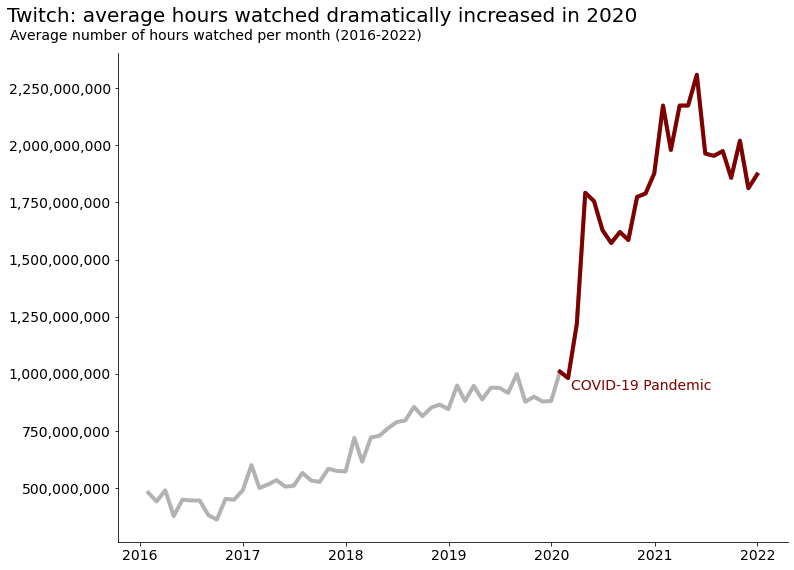

In [13]:
pandemic = twitch_global.loc["2020-01-31":]

fig, ax = plt.subplots(figsize = (12,9))

plt.plot(twitch_global.resample("M")["Hours_watched"].sum(), color = "grey", linewidth = 4, alpha = 0.6)
plt.plot(pandemic.resample("M")["Hours_watched"].sum(), color = "maroon", linewidth = 4)
# Change y tick labels to non-scientific notation
ax.ticklabel_format(useOffset=False, style='plain', axis = "y")

# Set x axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Twitch: average hours watched dramatically increased in 2020 ", size = 20, x = 0.31, y = 1.05)
plt.text(x = 16340, y = 2460000000, 
s= "Average number of hours watched per month (2016-2022)", size = 14)


# Remove borders
plt.gca().spines[["right", "top"]].set_visible(False)
plt.yticks(size = 14)
plt.xticks(size = 14)


plt.text(x = 18330, y = 930000000, 
s= "COVID-19 Pandemic", size = 14, color = "maroon")
plt.show()


In [14]:
steam_data.describe()

,average_players,peak_players,app_id,player_gain,player_gain_percentage,required_age,achievements,price_usd,review_score,total_positive,total_negative,rating,average_playtime,median_playtime,metacritic_score,year,release_year,release_month,age
count,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00,51942.00
mean,5803.58,11219.46,438313.71,-133.26,14348.79,2.47,63.42,20.70,7.35,49776.64,6228.47,82.61,2925.67,1058.94,81.23,2018.69,2015.48,6.83,6.52
std,36838.04,68895.73,364967.25,6273.96,1108054.41,6.07,119.40,15.86,1.87,170035.18,35032.29,11.72,4342.96,3150.74,5.46,2.52,3.91,3.47,3.91
min,0.00,0.00,10.00,-310597.48,-100.00,0.00,0.00,0.00,0.00,0.00,0.00,26.97,0.00,0.00,56.00,2012.00,1998.00,1.00,0.00
25%,372.12,780.00,221100.00,-133.64,-13.67,0.00,5.00,8.75,7.35,5068.00,628.00,78.84,905.00,286.00,81.23,2017.00,2013.00,4.00,4.00
50%,814.93,1708.00,346010.00,-6.88,-1.74,0.00,43.00,20.70,8.00,15987.00,1735.50,85.27,1636.00,566.00,81.23,2019.00,2016.00,7.00,6.00
75%,2288.91,4816.00,610370.00,80.81,11.84,0.00,71.00,28.85,8.00,43064.50,4100.00,90.65,3327.00,950.00,82.00,2021.00,2018.00,10.00,9.00
max,1584886.77,3236027.00,2011470.00,426446.12,162296033.94,18.00,1354.00,74.81,9.00,2949363.00,733480.00,97.64,41854.00,57446.00,97.00,2022.00,2022.00,12.00,24.00


### Ratings

https://steamdb.info/blog/steamdb-rating/

> If you've ever taken a slightly longer look at the Steam store, you've probably noticed their method of sorting games by review score is pretty bad. They just divide the positive reviews by the total reviews to get the rating. A game with a single positive review would be ranked above some other game that has 48 positive reviews and a single negative review. While they do have “steps” at 50 and 500 total reviews, meaning that no game with a rating of at least 80% will be ranked below a game with less than 50 reviews, and no game with a rating of at least 95% will be below a game with less than 500 reviews, it's still a bad system. Because if our 48 to 1 rated game suddenly accrued 11 more negative ratings, Steam would miraculously still place it higher than it was before.
> 
> I looked over some alternatives, including Wilson's formula that SteamDB used, but I didn't quite like any of them. Some sites seemed to have pretty good sorting formulas, but what exactly those formulas were not disclosed. So, I sat down to create my own, starting with trying to word the rules by which Steam's games should be sorted.
> 
> - Games with more reviews should have an adjusted rating that is closer to their real rating, because the more reviews we have, the more certain we are that the score they give us is correct.
> - All ratings should be biased towards the average rating — 50%.
>>\- Reddit user /u/tornmandate


- should avoid using metacritic score
- the default review score is clustered mostly near the median (around 80)
- the adjusted review score seems more "balanced"

When I plotted the relationship for all columns in the steam charts dataset, you probably noticed three columns that describe the current rating score for every game. The blog quoted above describes two of these columns ("review_score" and "rating"). The metacritic score is a separate website that rates video games on a scale of 0 to 100 (100 is highest). Earlier I spent time cleaning missing data for this column, but since about half the rows were missing scores, you'll notice how narrow the distribution is. 

The distribution of these other two columns is likely more representative of the population of Steam's review scores. However, making recommendations or decisions from the review score will not be helpful. It will not be helpful, because neither of these three columns has a strong relationship with other columns. The rating of a game is not a good predictor of the number of people playing a game on Steam.


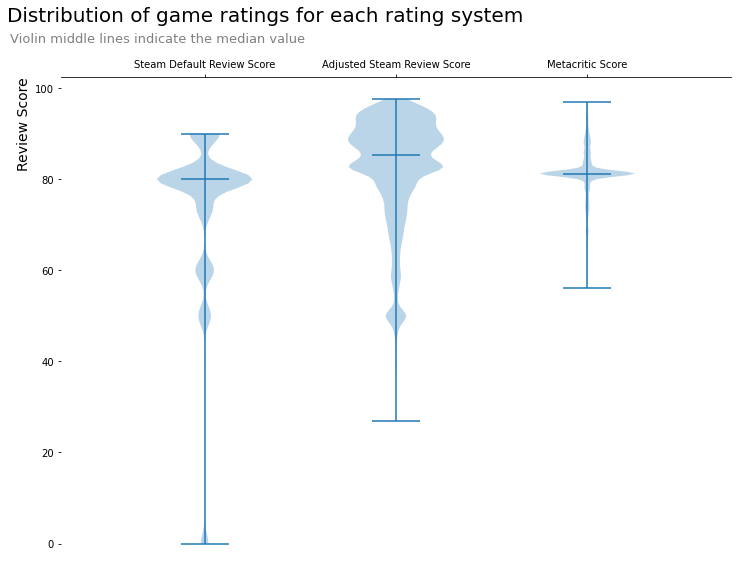

In [15]:
# Define a function for setting the styling of the axis
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.xaxis.tick_top()
    ax.set_ylabel("Review Score", size = 14, loc = "top")

# Title of each rating system available
titles = ["Steam Default Review Score","Adjusted Steam Review Score","Metacritic Score"]

# Assign variables to each "rating" column
review_score = steam_data["review_score"] * 10 # <- multiply this column by 10 to scale appropriately with other two columns
rating = steam_data["rating"]
metacritic_score = steam_data["metacritic_score"]

# Plot results
fig, ax = plt.subplots(figsize = (12,9))
plt.violinplot([review_score, rating, metacritic_score], showmedians=True)

# Remove all borders except top border
plt.gca().spines[["right", "left","bottom"]].set_visible(False)

# Title and subtext
plt.title("Distribution of game ratings for each rating system", size = 20, x = 0.305, y = 1.1)
plt.text(x = -.015, y = 110, s = "Violin middle lines indicate the median value", size = 13, color = "grey")
set_axis_style(ax, titles)

In [16]:
correlation_1 = round(steam_data["review_score"].corr(steam_data["average_players"]), 2)

correlation_2 = round(steam_data["rating"].corr(steam_data["average_players"]), 2)


print(f"Correlation between review score and the average monthly player count: {correlation_1}")

print(f"Correlation between the adjusted review score (rating) and the average monthly player count: {correlation_2} ")


Correlation between review score and the average monthly player count: 0.02
Correlation between the adjusted review score (rating) and the average monthly player count: -0.01 


Text(-1.6, 1710000, 'The relationship between the review score and the\nassociated number of monthly players is nearly non-existent')

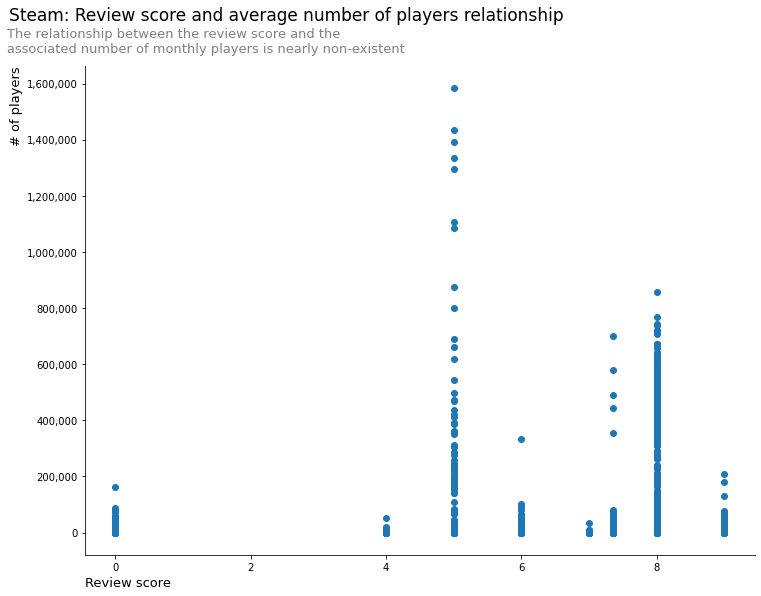

In [17]:
fig,ax = plt.subplots(figsize=(12,9))
plt.scatter(steam_data["review_score"], steam_data["average_players"])
#sns.regplot(steam_data["review_score"], steam_data["average_players"])
# Change y tick labels to non-scientific notation
ax.ticklabel_format(useOffset=False, style='plain', axis = "y")

# Set y axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.xlabel("Review score", size = 13, loc = "left")
plt.ylabel("# of players", size = 13, loc = "top")

plt.gca().spines[["right", "top"]].set_visible(False)

plt.title("Steam: Review score and average number of players relationship", size = 17, x = 0.3, y= 1.08)
plt.text(x=-1.6, y=1710000, s='''The relationship between the review score and the
associated number of monthly players is nearly non-existent''', size = 13, color = "grey")

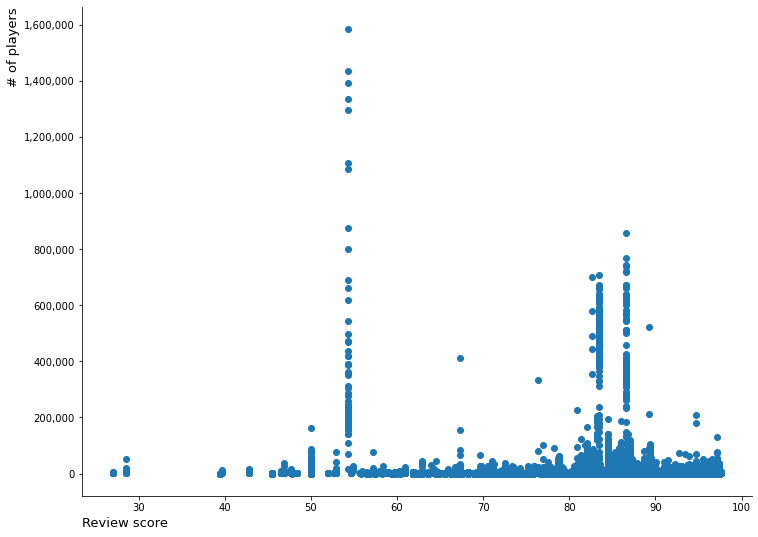

In [18]:
fig,ax = plt.subplots(figsize=(12,9))
plt.scatter(steam_data["rating"], steam_data["average_players"])
# Change y tick labels to non-scientific notation
ax.ticklabel_format(useOffset=False, style='plain', axis = "y")

# Set y axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.xlabel("Review score", size = 13, loc = "left")
plt.ylabel("# of players", size = 13, loc = "top")

plt.gca().spines[["right", "top"]].set_visible(False)

In [19]:
steam_data[['game','total_positive','total_negative','review_score','rating','metacritic_score']]

,game,total_positive,total_negative,review_score,rating,metacritic_score
month,,,,,,
2022-06-30,Counter-Strike: Global Offensive,2949363.00,439344.00,8.00,86.63,83.00
2022-05-31,Counter-Strike: Global Offensive,2949363.00,439344.00,8.00,86.63,83.00
2022-04-30,Counter-Strike: Global Offensive,2949363.00,439344.00,8.00,86.63,83.00
2022-03-31,Counter-Strike: Global Offensive,2949363.00,439344.00,8.00,86.63,83.00
2022-02-28,Counter-Strike: Global Offensive,2949363.00,439344.00,8.00,86.63,83.00
...,...,...,...,...,...,...
2020-06-30,Stoneshard,15281.00,4705.00,6.00,75.12,81.23
2020-05-31,Stoneshard,15281.00,4705.00,6.00,75.12,81.23
2020-04-30,Stoneshard,15281.00,4705.00,6.00,75.12,81.23


In [20]:
playtime = steam_data.groupby("game")[["median_playtime","average_playtime"]].mean()
playtime.sort_values(by="average_playtime",ascending=False).head(20)

,median_playtime,average_playtime
game,,
Firestone Idle RPG,48663.00,41854.00
Gems of War,1375.00,41285.00
X-Plane 11,57446.00,38676.00
Dota 2,896.00,37871.00
Counter-Strike: Global Offensive,6104.00,30053.00
PUBG: BATTLEGROUNDS,7525.00,22858.00
Battle Brothers,38101.00,22718.00
FINAL FANTASY XIV Online,5409.00,22149.00
Cookie Clicker,11260.00,19308.00


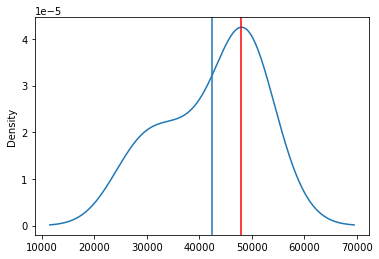

In [21]:
list = [26000,30000,30000,35000,39000,40000,48000,48000,48000,48000,48000,50000,49000,55000]
sum(list) / len(list)
list = pd.Series(list)
list.plot.kde()
plt.axvline(list.mean())
plt.axvline(list.median(), color = "red")

In [22]:
twitch_global.describe()

,Hours_watched,Avg_viewers,Peak_viewers,Streams,Avg_channels,Games_streamed
count,72.00,72.00,72.00,72.00,72.00,72.00
mean,1042294502.22,1426985.96,3003735.96,13934321.11,54572.43,21615.32
std,586050234.60,799579.66,1582052.31,5539751.88,33246.32,7768.37
min,362833210.00,504635.00,1186009.00,5507554.00,16592.00,12134.00
25%,534936067.25,746080.75,1750812.75,8282278.25,24588.00,15701.25
50%,871857012.00,1195169.50,2473509.00,14460996.00,45559.50,19431.50
75%,1622832490.50,2220380.75,4084978.75,17905686.00,91888.00,25418.25
max,2308295297.00,3106723.00,6516666.00,25614207.00,122763.00,36960.00


In [23]:
steam_data.columns

Index(['average_players', 'peak_players', 'app_id', 'game', 'player_gain',
       'player_gain_percentage', 'short_description', 'required_age', 'dlc',
       'supported_languages', 'developers', 'publishers', 'platforms',
       'categories', 'genres', 'achievements', 'release_date',
       'supported_audio', 'price_usd', 'review_score', 'total_positive',
       'total_negative', 'rating', 'total_owners_estimated',
       'average_playtime', 'median_playtime', 'tags', 'metacritic_score',
       'metacritic_url', 'is_recurring_subscription', 'year', 'month_name',
       'release_year', 'release_month', 'age'],
      dtype='object')

### Seasonal trends

At first glance there appears to be some seasonality. This was first noticed in the initial data exploration phase. Twitch viewership appears to flucate over the years, and a similar pattern is noticed in the steam charts data. 

In [24]:
hours_watched = twitch_global.sort_index()["Hours_watched"]
hours_watched

date
2016-01-31     480241904
2016-02-29     441859897
2016-03-31     490669308
2016-04-30     377975447
2016-05-31     449836631
                 ...    
2021-08-31    1974586275
2021-09-30    1857514531
2021-10-31    2020197953
2021-11-30    1812117484
2021-12-31    1872400661
Name: Hours_watched, Length: 72, dtype: int64

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

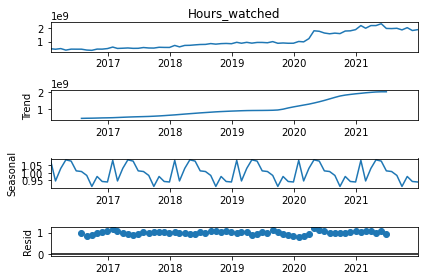

In [25]:

plt.figure(figsize = (12,9))
result = seasonal_decompose(hours_watched,model = "multiplicative")
#steam_data["average_players"].plot()
plt.figure(figsize = (12,9))
result.plot();

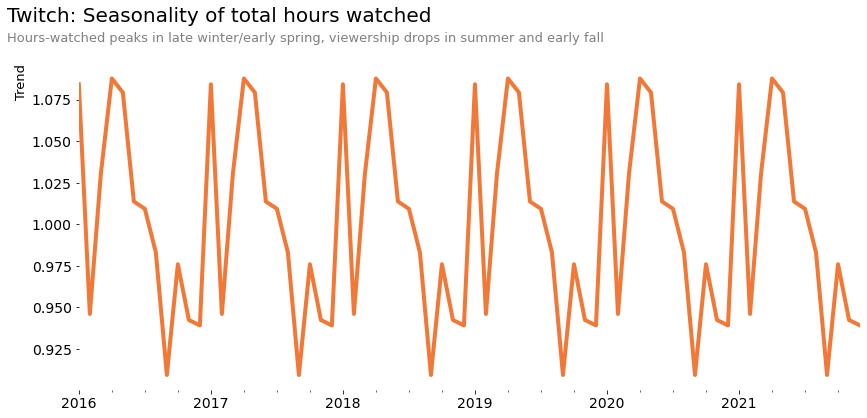

In [26]:
result.seasonal.plot(figsize = (14,6), linewidth = 4, color = "#f17837")
# Change y tick labels to non-scientific notation
#plt.ticklabel_format(useOffset=False, style='plain', axis = "y")

# Remove borders and x label
plt.gca().spines[["right", "left", "top", "bottom"]].set_visible(False)
plt.xlabel("")

# Y label
plt.ylabel("Trend", loc = "top", size = 13)

# X and Y ticks
plt.yticks(size = 14)
plt.xticks(size = 14)

# Title and subtext
plt.title("Twitch: Seasonality of total hours watched", x=0.18, y=1.11, size = 20)
plt.text(x = 545.5, y = 1.11,

s ="Hours-watched peaks in late winter/early spring, viewership drops in summer and early fall", size = 13, color = "grey")

plt.show()

### Steam data player spike 2018
Refer to this link:

*https://arstechnica.com/gaming/2018/08/is-fortnite-to-blame-for-steams-falling-user-numbers-this-year/*

In the chart above, *Steam: total monthly players (2012 - 2022)* you'll notice about three large peaks. One in 2018, mid-late 2020, and 2022. The last two are more easily explained by COVID-19 lockdowns indirectly inflating player counts on Valve's platform. The 2018 peak is less explainable, so I did some searching online and found an article written in August 2018 (link above).

To summarize, the article explains it's possible that the most popular title in 2018 (on Steam), *Playerunknown's Battlegrounds*, experienced a significant increase in average player count in January 2018 with a significant loss by the end of the year. This article mentions that during this time, Epic Games (a competitor to Valve's Steam client) released *Fortnite*. As both titles have similar gameplay, the popularity of this title may have had an diverted player interest away from *Playerunknown's Battlegrounds*. 
In short, *Playerunknown's Battlegrounds*' average monthly player count drastically skewed the overall average player count in late 2017 to mid 2018.

To verify this within the data locally, I sliced the steam charts data to include all rows only from the start of 2017 to the end of 2018. With this slice I performed data filtering to only include rows that have values in the "average_players" column that are greater than the overall average "average_players" of this slice. Further sorting shows that during this time period *Playerunknown's Battlegrounds* had the highest average player count for several months.



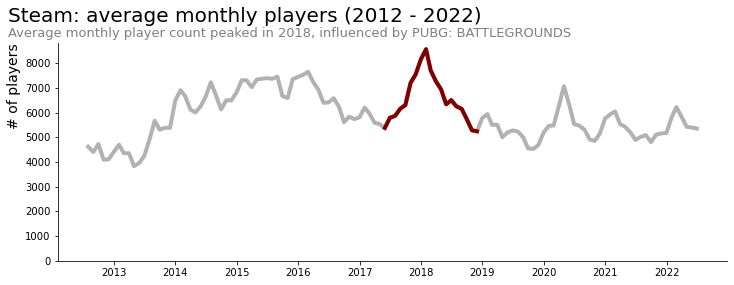

In [27]:
y_2017_2018 = steam_data.loc["2017-05-01":"2018-12-01"]
# Plot results
fig, ax = plt.subplots(figsize = (12,4))


# Resample the player data on a monthly scale, calculate the sum
plt.plot(steam_data.resample("M")["average_players"].mean(), linewidth = 4, color = "grey", alpha = 0.6)
plt.plot(y_2017_2018.resample("M")["average_players"].mean(), color = "maroon", linewidth = 4)
#plt.axvline(dt.datetime(2020, 3, 15), color = "grey")
#plt.axvspan(dt.datetime(2020,3,15),dt.datetime(2023,1,1), color = "black", alpha = 0.2)
plt.ylabel("# of players", size = 14, loc = "top")

# Remove borders
plt.gca().spines[["right", "top"]].set_visible(False)

plt.title("Steam: average monthly players (2012 - 2022)", size = 20, x = 0.28, y = 1.07)
plt.text(x = 15075, y = 9050,
s = "Average monthly player count peaked in 2018, influenced by PUBG: BATTLEGROUNDS",
size = 13, color = "grey")
plt.ylim(0)
plt.show()

In [28]:
# Slice steam charts data from 2017 to 2018
y_2017_2018 = steam_data.loc["2017-01-01":"2019-01-01"]

# Filter sliced dataframe for rows with greater than average values in average_players column
# Reassign to new variable
above_avg_17_18 = y_2017_2018[y_2017_2018["average_players"] > y_2017_2018["average_players"].mean()]

# Slice dataframe to include only game and average_players columns
# Sort by average_players in descending order
# Reassign to new variable
player_averages = above_avg_17_18[["game","average_players"]].sort_values(by = "average_players", ascending = False)

# Drop duplicates of based on name of game
player_averages.drop_duplicates(subset = "game", keep = "first").head(10)

,game,average_players
month,,
2018-01-31,PUBG: BATTLEGROUNDS,1584886.77
2017-02-28,Dota 2,591567.25
2017-02-28,Counter-Strike: Global Offensive,402385.71
2018-08-31,Monster Hunter: World,188291.24
2018-03-31,Tom Clancy's Rainbow Six Siege,83112.29
2017-06-30,PAYDAY 2,80779.88
2018-07-31,Grand Theft Auto V,80395.34
2018-07-31,Warframe,76594.91
2017-10-31,Team Fortress 2,54963.29


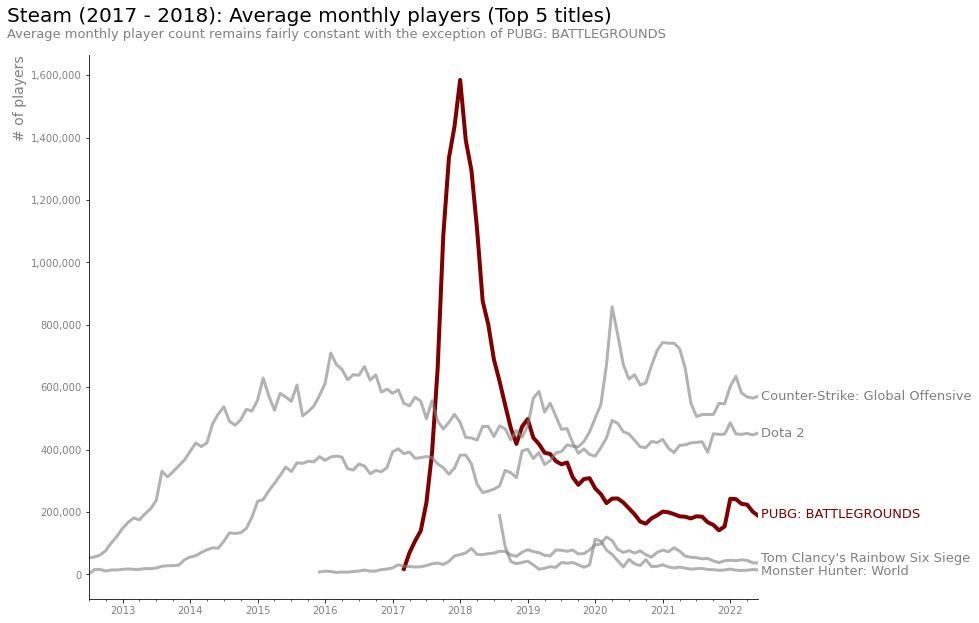

In [60]:

# Top 5 games with the highest average monthly player count (2017 to 2018)
pubg = steam_data[steam_data["game"] == "PUBG: BATTLEGROUNDS"]
dota = steam_data[steam_data["game"] == "Dota 2"]
csgo = steam_data[steam_data["game"] == "Counter-Strike: Global Offensive"]
mhw = steam_data[steam_data["game"] == "Monster Hunter: World"]
rss = steam_data[steam_data["game"] == "Tom Clancy's Rainbow Six Siege"]


# Plot results
fig, ax = plt.subplots(figsize = (12,10))
ax1 = pubg.resample("M")["average_players"].mean().plot(linewidth = 4, color = "maroon")
ax2 = dota.resample("M")["average_players"].mean().plot(linewidth = 3, color = "grey", alpha = 0.6)
ax3 = csgo.resample("M")["average_players"].mean().plot(linewidth = 3, color = "grey", alpha = 0.6)
ax4 = mhw.resample("M")["average_players"].mean().plot(linewidth = 3, color = "grey", alpha = 0.6)
ax5 = rss.resample("M")["average_players"].mean().plot(linewidth = 3, color = "grey", alpha = 0.6)

# Remove scientific notation y axis
ax.ticklabel_format(useOffset=False, style='plain', axis = "y")

# Set y axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Remove x label
plt.xlabel("")
plt.ylabel("# of players",size = 14, loc = "top", color = "grey")

# Labels
plt.text(629.5,180000,"PUBG: BATTLEGROUNDS", color = "maroon", size = 13)
plt.text(629.5,440000,"Dota 2", color = "grey", size = 13)
plt.text(629.5,560000,"Counter-Strike: Global Offensive", color = "grey", size = 13)
plt.text(629.5,0,"Monster Hunter: World", color = "grey", size = 13)
plt.text(629.5,40000,"Tom Clancy's Rainbow Six Siege", color = "grey", size = 13)

plt.yticks(color = "grey")
plt.xticks(color = "grey")
# Remove spines
plt.gca().spines[["right", "top"]].set_visible(False)

plt.title("Steam (2017 - 2018): Average monthly players (Top 5 titles)", size = 20, x = 0.33, y = 1.05)
plt.text(x = 495.5, y = 1720000,
s = "Average monthly player count remains fairly constant with the exception of PUBG: BATTLEGROUNDS", 
size = 13, color = "grey")

plt.show()

### Twitch game data

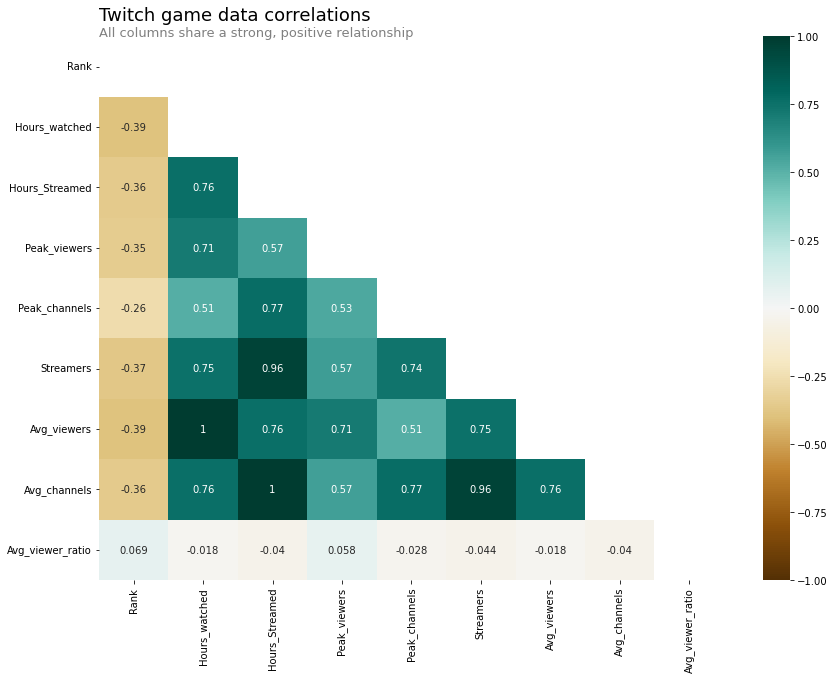

In [30]:
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(twitch_game.corr(), dtype=bool))

heatmap = sns.heatmap(twitch_game.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title("Twitch game data correlations", fontdict={'fontsize':18}, pad=16, loc = "left")
plt.text(x = 0, y = 0, s = "All columns share a strong, positive relationship ", size = 13, color = "grey")
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

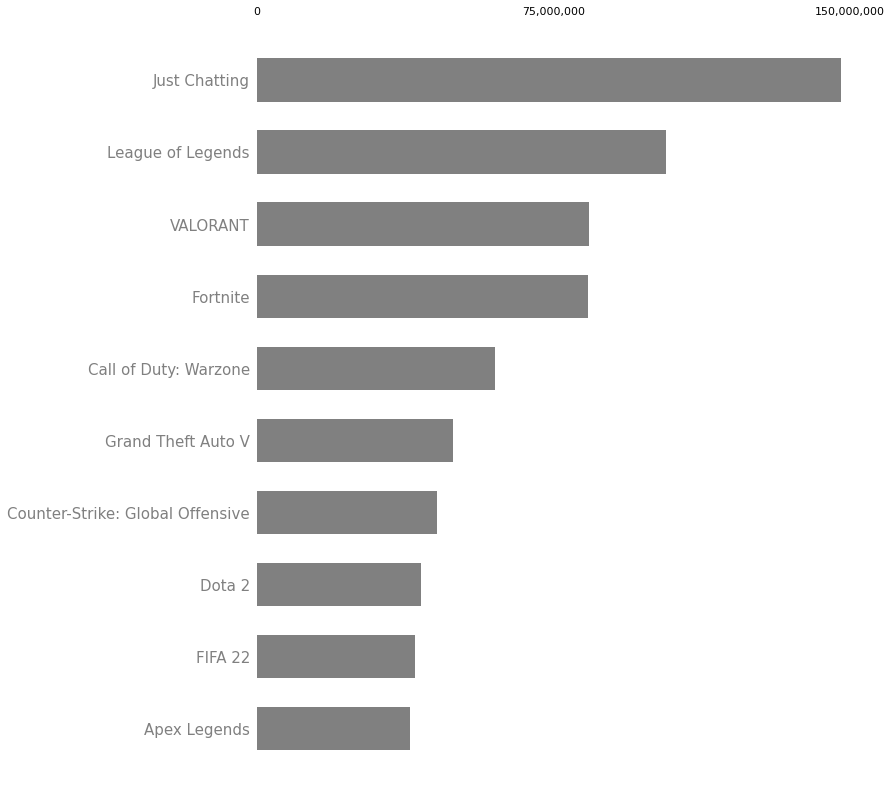

In [53]:
top_10 = twitch_game.groupby("Game", as_index=False).mean().sort_values(by="Hours_watched",ascending=False).head(10)

fig,ax = plt.subplots(figsize = (11,14))
plt.barh(top_10["Game"], top_10["Hours_watched"], color = "grey", height = 0.6)
plt.gca().invert_yaxis()
ax.set_xticks([0, 75000000, 150000000])

# Change x tick labels to non-scientific notation
ax.ticklabel_format(useOffset=False, style='plain', axis = "x")


# Set x axis ticks with commas
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Remove borders
plt.gca().spines[["right", "left", "top", "bottom"]].set_visible(False)

# X axis to top
ax.xaxis.tick_top()
ax.tick_params(bottom=False, left=False)
ax.tick_params(top=False, left=False)
# X and Y ticks
plt.xticks(size = 11)
plt.yticks(size = 15, color = "grey")

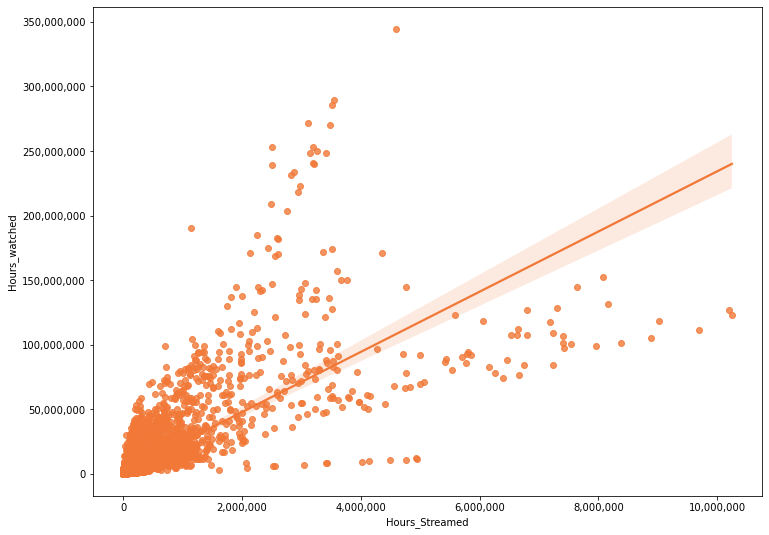

In [32]:
fig,ax=plt.subplots(figsize = (12,9))
sns.regplot(x="Hours_Streamed", y="Hours_watched",data=twitch_game, color = "#f17837")
ax.ticklabel_format(useOffset=False, style='plain', axis = "y")
# Set x axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
# Set x axis ticks with commas
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))


In [33]:
# Monthly top 200 games on twitch
twitch_game

,Game,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
date,,,,,,,,,,
2016-01-31,League of Legends,1,94377226,1362044,530270,2903,129172,127021,1833,69.29
2016-01-31,Counter-Strike: Global Offensive,2,47832863,830105,372654,2197,120849,64378,1117,57.62
2016-01-31,Dota 2,3,45185893,433397,315083,1100,44074,60815,583,104.26
2016-01-31,Hearthstone,4,39936159,235903,131357,517,36170,53749,317,169.29
2016-01-31,Call of Duty: Black Ops III,5,16153057,1151578,71639,3620,214054,21740,1549,14.03
...,...,...,...,...,...,...,...,...,...,...
2021-12-31,Garry's Mod,196,630902,21753,24951,99,3537,849,29,29.00
2021-12-31,Call of Duty: Black Ops Cold War,197,622497,223641,26559,654,25366,837,300,2.78
2021-12-31,Noita,198,620983,13935,27826,41,1961,835,18,44.56


In [34]:
twitch_game["month"] = twitch_game.index.month_name()

In [35]:
twitch_game.describe()

,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
count,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00,14399.00
mean,100.50,4782757.99,157125.30,55096.80,586.40,17224.46,6554.21,214.87,81.88
std,57.74,16679490.00,542829.50,132917.88,2721.16,54533.41,22859.34,743.88,368.89
min,1.00,89811.00,19.00,441.00,1.00,0.00,120.00,0.00,1.95
25%,50.50,368179.00,12212.00,8351.00,51.50,1479.00,504.00,16.00,16.12
50%,100.00,819895.00,31630.00,20169.00,122.00,4126.00,1125.00,43.00,29.16
75%,150.00,2295441.00,88728.00,45986.00,318.00,10712.00,3159.00,121.00,57.80
max,200.00,344551979.00,10245704.00,3123208.00,129860.00,1013029.00,479209.00,13789.00,13601.87


### Twitch games with positive Steam player growth
Logic here is that we should only be interested in games that have positive player growth on steam. By extension, twitch viewers will more likely be interested in games that have an active player base.

In [36]:
player_gain = steam_data.groupby("game")["player_gain"].mean()

print(f"Positive growth: {len(player_gain[player_gain >= 0])} games")

print(f"Negative growth: {len(player_gain[player_gain < 0])} games")

# Titles with greater than 0 player gain
positive_growth = player_gain[player_gain >= 0].index.to_list()


Positive growth: 465 games
Negative growth: 514 games


In [37]:
positive_growth

['100% Orange Juice',
 '20 Minutes Till Dawn',
 '3DMark',
 '7 Days to Die',
 'A Dance of Fire and Ice',
 'A Total War Saga: Thrones of Britannia',
 'ARK: Survival Evolved',
 'ASTRONEER',
 'Action! - Gameplay Recording and Streaming',
 'Age of History II',
 'Age of Mythology: Extended Edition',
 'Age of Wonders III',
 'Aim Lab',
 'Albion Online',
 'Alien Swarm: Reactive Drop',
 'American Truck Simulator',
 'Animal Revolt Battle Simulator',
 'Animaze',
 'Anno 1404 - History Edition',
 'Apex Legends',
 'Arma 3',
 'Aseprite',
 'Assetto Corsa',
 'Assetto Corsa Competizione',
 'Automation - The Car Company Tycoon Game',
 'Automobilista 2',
 'Avorion',
 'Axis & Allies 1942 Online',
 'BATTLETECH',
 "Baldur's Gate: Enhanced Edition",
 'Banished',
 'Barotrauma',
 'Batman: Arkham City GOTY',
 'Battle Brothers',
 'Battlefield 1 ™',
 'Battlefield 4™',
 'Battlefield™ V',
 'BeamNG.drive',
 'Beasts of Bermuda',
 'Beat Saber',
 'Bejeweled 3',
 'Bitburner',
 'Black Desert',
 'Black Desert Online SA',
 '

In [38]:
# Provide a filter for games in twich dataset
# Filters out games that do not have positive growth in Steam charts data
active_games = twitch_game[twitch_game["Game"].isin(positive_growth)]

Counter strike: steam

dota 2: steam

apex legends: multi

dead by daylight: multi

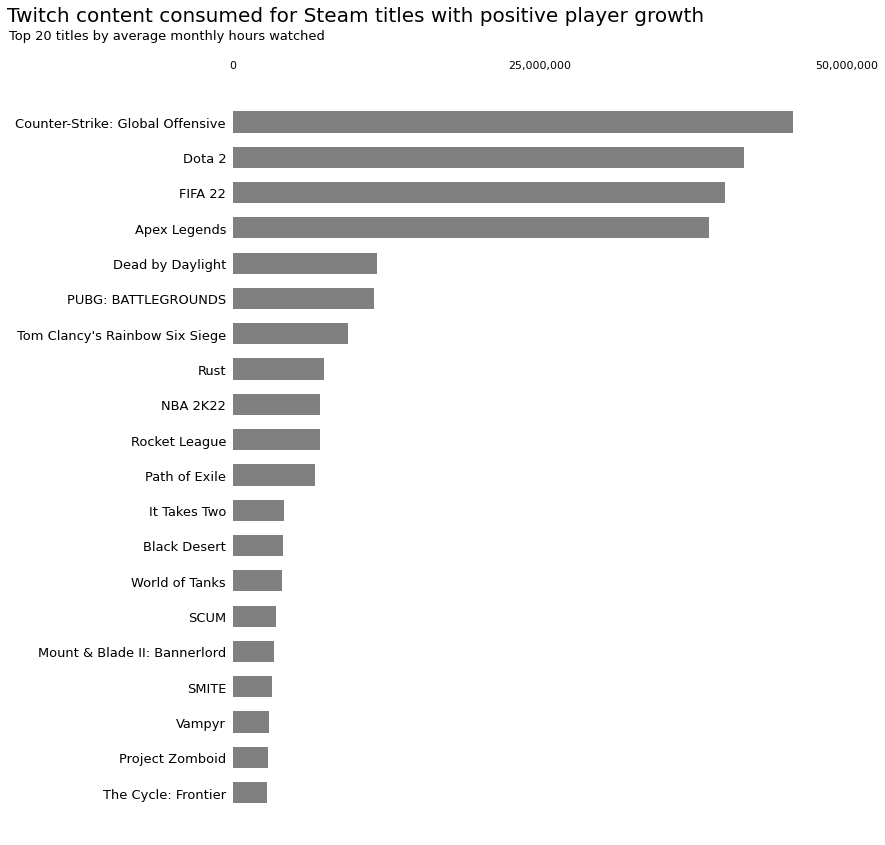

In [39]:
top_20_hours_watched = active_games.groupby("Game", as_index=False).mean().sort_values(by="Hours_watched",ascending=False).head(20)

fig,ax = plt.subplots(figsize = (11,14))
plt.barh(top_20_hours_watched["Game"], top_20_hours_watched["Hours_watched"], color = "grey", height = 0.6)
plt.gca().invert_yaxis()
ax.set_xticks([0, 25000000, 50000000])

# Change x tick labels to non-scientific notation
ax.ticklabel_format(useOffset=False, style='plain', axis = "x")


# Set x axis ticks with commas
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Remove borders
plt.gca().spines[["right", "left", "top", "bottom"]].set_visible(False)

# X axis to top
ax.xaxis.tick_top()
ax.tick_params(bottom=False, left=False)
ax.tick_params(top=False, left=False)
# X and Y ticks
plt.xticks(size = 11)
plt.yticks(size = 13)

# Title
plt.title("Twitch content consumed for Steam titles with positive player growth", size = 20, x = 0.2, y = 1.065)
plt.text(x=-18240000, y =-2.35, s="Top 20 titles by average monthly hours watched", size = 13)

plt.show()

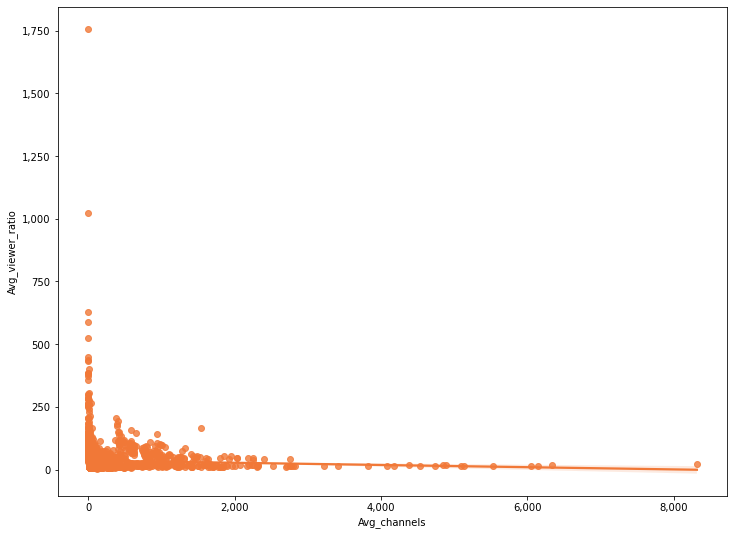

In [40]:
fig,ax=plt.subplots(figsize = (12,9))
sns.regplot(x="Avg_channels", y="Avg_viewer_ratio",data=active_games, color = "#f17837")
ax.ticklabel_format(useOffset=False, style='plain', axis = "y")
# Set x axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
# Set x axis ticks with commas
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

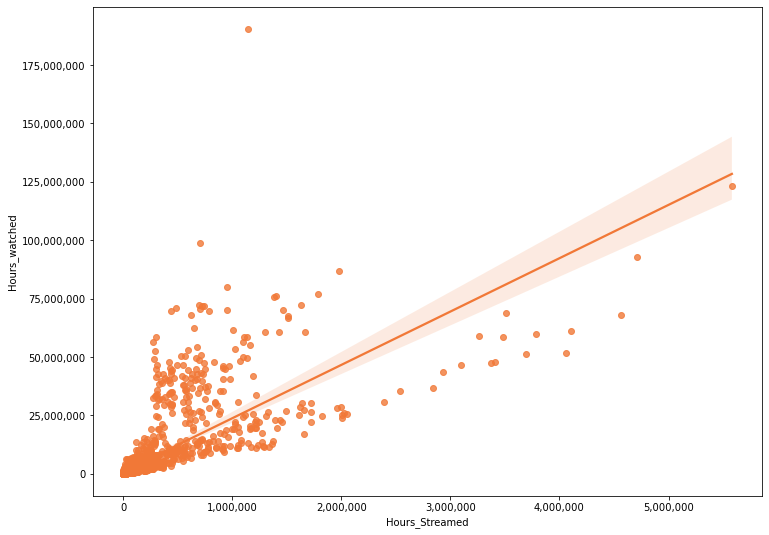

In [41]:
fig,ax=plt.subplots(figsize = (12,9))
sns.regplot(x="Hours_Streamed", y="Hours_watched",data=active_games, color = "#f17837")
ax.ticklabel_format(useOffset=False, style='plain', axis = "y")
# Set x axis ticks with commas
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
# Set x axis ticks with commas
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

### Average channels/ viewer ratio
Average channels might indicate whether or not games are oversaturated with content creators.
Average viewer ratio describes the average number of viewers per channel that belong to a certain game
May want to find a game that does not have too many channels, but has a "good" viewer ratio
average channels is the average amount of channels per day:

    if you stream the same game twice in the same day it counts as one
    if you stream the game two different days it counts as two
    as the data here is monthly you can calculate average channels with
    (#unique channels in day 1 + #unique channels in day 2 + … + #unique channels in day 30)/30


In [42]:
active_games.describe()
# Avg channels typcially 23 to 175 channels
# Avg viewer ratio typically 13 to 40 viewers
# Avg_viewer_ratio is roughly the result of Avg_viewers / Avg_channels

,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
count,3219.00,3219.00,3219.00,3219.00,3219.00,3219.00,3219.00,3219.00,3219.00
mean,98.62,4333973.50,147338.11,48728.76,455.55,16576.10,5944.92,201.65,34.87
std,58.35,11324934.18,362272.65,108608.26,1051.44,37809.77,15553.22,499.82,54.68
min,1.00,95310.00,383.00,703.00,7.00,0.00,130.00,0.00,3.09
25%,47.00,366002.00,16892.00,7723.00,62.50,2376.00,499.50,23.00,13.75
50%,99.00,831995.00,42429.00,18372.00,146.00,5381.00,1127.00,57.00,22.47
75%,149.00,2436056.50,113153.50,39945.00,351.00,11746.00,3326.50,153.00,38.39
max,200.00,190468488.00,5580337.00,1916027.00,18932.00,663781.00,256350.00,8316.00,1756.77


In [43]:
# over time average channels and viewer ratio
active_games.groupby("Game").mean()[["Avg_channels","Avg_viewer_ratio","Hours_watched"]].sort_values(by="Avg_channels",ascending=False).head(30)

,Avg_channels,Avg_viewer_ratio,Hours_watched
Game,,,
Apex Legends,3556.57,14.17,38776835.31
Counter-Strike: Global Offensive,1255.07,51.37,45654183.57
FIFA 22,995.25,64.27,40056458.50
Tom Clancy's Rainbow Six Siege,917.56,13.91,9375962.67
Dead by Daylight,801.37,24.07,11705535.37
NBA 2K22,716.25,12.77,7079720.00
PUBG: BATTLEGROUNDS,678.00,23.08,11470067.71
Dota 2,642.19,95.14,41632479.08
Rocket League,558.33,17.69,7060146.61


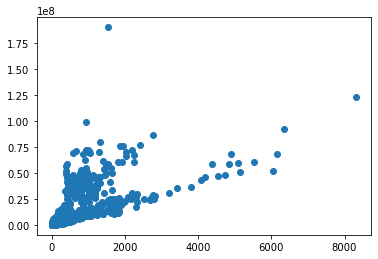

In [44]:
plt.scatter(active_games["Avg_channels"], active_games["Hours_watched"])

{'bodies': [<matplotlib.collections.PolyCollection at 0x2d3b26a80d0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x2d3b26a84f0>,
 'cmins': <matplotlib.collections.LineCollection at 0x2d3b2b7e040>,
 'cbars': <matplotlib.collections.LineCollection at 0x2d3b2b7e190>}

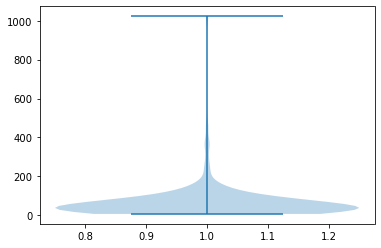

In [45]:
grouped_active_games = active_games.groupby("Game").mean()
plt.violinplot(grouped_active_games["Avg_viewer_ratio"])

In [46]:
grouped_active_games

,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
Game,,,,,,,,,
7 Days to Die,109.19,871840.44,76893.32,11655.31,225.61,7236.19,1189.56,104.67,11.33
A Dance of Fire and Ice,141.00,452164.00,7002.00,20901.00,55.00,2833.00,645.00,9.50,69.94
ARK: Survival Evolved,53.13,2099060.44,146718.95,25852.30,406.40,12809.59,2892.92,201.10,14.65
ASTRONEER,101.17,767350.67,21185.17,30406.33,99.33,2990.00,1063.33,29.17,36.38
Albion Online,147.79,688408.76,37563.14,8904.62,110.48,2618.66,941.28,51.03,19.27
...,...,...,...,...,...,...,...,...,...
World of Warships,73.07,1523980.18,50019.47,12063.24,143.03,3896.44,2087.06,68.04,27.19
Worms W.M.D,151.43,453976.71,2028.86,39330.29,21.43,559.57,621.29,2.14,241.73
Wreckfest,121.00,584017.67,10751.00,44637.67,52.00,2143.33,798.00,14.00,52.93


In [47]:
grouped_active_games[grouped_active_games.index == "Counter-Strike: Global Offensive"]

,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
Game,,,,,,,,,
Counter-Strike: Global Offensive,5.65,45654183.57,915642.89,470829.17,2502.46,120757.88,62647.82,1255.07,51.37


In [48]:
active_games.head()

,Game,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,month
date,,,,,,,,,,,
2016-01-31,Counter-Strike: Global Offensive,2,47832863,830105,372654,2197,120849,64378,1117,57.62,January
2016-01-31,Dota 2,3,45185893,433397,315083,1100,44074,60815,583,104.26,January
2016-01-31,World of Tanks,15,4993627,128356,39358,368,16121,6720,172,38.90,January
2016-01-31,Tom Clancy's Rainbow Six Siege,16,4866039,242134,25742,694,42244,6549,325,20.10,January
2016-01-31,SMITE,20,3788701,114041,70542,296,15389,5099,153,33.22,January


{'bodies': [<matplotlib.collections.PolyCollection at 0x2d3b25b29d0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x2d3b25b2a90>,
 'cmins': <matplotlib.collections.LineCollection at 0x2d3b2910340>,
 'cbars': <matplotlib.collections.LineCollection at 0x2d3b2910670>}

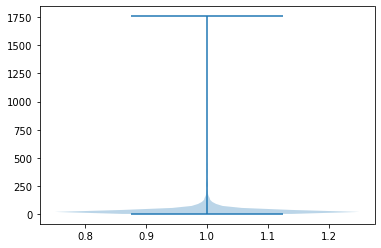

In [49]:
plt.violinplot(active_games["Avg_viewer_ratio"])